# Azure embeddings example

This example will cover embeddings using the Azure OpenAI service.

## Setup

First, we install the necessary dependencies and import the libraries we will be using.

In [ ]:
! pip install "openai>=1.0.0,<2.0.0"
! pip install python-dotenv

In [6]:
import os
import openai
import dotenv

dotenv.load_dotenv()

True

### Authentication

The Azure OpenAI service supports multiple authentication mechanisms that include API keys and Azure Active Directory token credentials.

In [7]:
use_azure_active_directory = False  # Set this flag to True if you are using Azure Active Directory

#### Authentication using API key

To set up the OpenAI SDK to use an *Azure API Key*, we need to set `api_key` to a key associated with your endpoint (you can find this key in *"Keys and Endpoints"* under *"Resource Management"* in the [Azure Portal](https://portal.azure.com)). You'll also find the endpoint for your resource here.

In [8]:
if not use_azure_active_directory:
    endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
    api_key = os.environ["AZURE_OPENAI_API_KEY"]

    client = openai.AzureOpenAI(
        azure_endpoint=endpoint,
        api_key=api_key,
        api_version="2023-09-01-preview"
    )

#### Authentication using Azure Active Directory
Let's now see how we can authenticate via Azure Active Directory. We'll start by installing the `azure-identity` library. This library will provide the token credentials we need to authenticate and help us build a token credential provider through the `get_bearer_token_provider` helper function. It's recommended to use `get_bearer_token_provider` over providing a static token to `AzureOpenAI` because this API will automatically cache and refresh tokens for you. 

For more information on how to set up Azure Active Directory authentication with Azure OpenAI, see the [documentation](https://learn.microsoft.com/azure/ai-services/openai/how-to/managed-identity).

In [ ]:
! pip install "azure-identity>=1.15.0"

In [10]:
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

if use_azure_active_directory:
    endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
    api_key = os.environ["AZURE_OPENAI_API_KEY"]

    client = openai.AzureOpenAI(
        azure_endpoint=endpoint,
        azure_ad_token_provider=get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"),
        api_version="2023-09-01-preview"
    )

> Note: the AzureOpenAI infers the following arguments from their corresponding environment variables if they are not provided:

- `api_key` from `AZURE_OPENAI_API_KEY`
- `azure_ad_token` from `AZURE_OPENAI_AD_TOKEN`
- `api_version` from `OPENAI_API_VERSION`
- `azure_endpoint` from `AZURE_OPENAI_ENDPOINT`


## Deployments

In this section we are going to create a deployment of a model that we can use to create embeddings.

### Deployments: Create in the Azure OpenAI Studio
Let's deploy a model to use with embeddings. Go to https://portal.azure.com, find your Azure OpenAI resource, and then navigate to the Azure OpenAI Studio. Click on the "Deployments" tab and then create a deployment for the model you want to use for embeddings. The deployment name that you give the model will be used in the code below.

In [11]:
deployment = "text-embedding-ada-002" # Fill in the deployment name from the portal here

## Embeddings

Now let's create embeddings using the client we built.

In [12]:
embeddings = client.embeddings.create(
    model=deployment,
    input="Me gustan los animales"
)
                                
print(embeddings)

CreateEmbeddingResponse(data=[Embedding(embedding=[-0.01759173721075058, 4.636823547343738e-08, -0.008801803924143314, -0.003285096725448966, -0.0204168614000082, 0.018778763711452484, -0.006404009647667408, -0.008789933286607265, 0.006421815138310194, -0.020488083362579346, 0.0075910366140306, 0.012594354338943958, 0.01930105686187744, -0.01955033279955387, 0.004911323543637991, 0.012119543738663197, 0.021129077300429344, -0.0003201263025403023, 0.017413683235645294, 0.003786615561693907, -0.005638377275317907, 0.029936816543340683, 0.004294069483876228, -0.036489203572273254, -0.002541721099987626, 0.0014733970165252686, 0.011169922538101673, -0.01182278711348772, 0.0012730862945318222, -0.023336946964263916, 0.04221067577600479, -0.02502252534031868, -0.0027613211423158646, -0.02488008327782154, -0.012125479057431221, -0.028037574142217636, -0.004157561343163252, -0.013722030445933342, -0.0034156697802245617, 0.0030417563393712044, -0.006178474519401789, 0.03553958237171173, 0.00157

# Ejercicio 1: Generar múltiples embeddings y calcular similitud entre frases
## Objetivo: Aprender a generar embeddings para múltiples textos y calcular similitudes entre ellos.


In [13]:
# Lista de textos a procesar
texts = [
    "El clima está soleado y cálido.",
    "Hace frío y está lloviendo.",
    "Me encanta pasar tiempo en la playa.",
    "Leer libros en casa durante un día lluvioso es relajante."
]

# Crear embeddings para cada texto
embeddings_list = []
for text in texts:
    response = client.embeddings.create(
        model=deployment,
        input=text
    )
   
    # Acceder a los embeddings correctamente
    embedding = response.data[0].embedding  # Cambiado a response.data[0].embedding
    embeddings_list.append(embedding)

# Calcular la similitud coseno entre embeddings
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_matrix = cosine_similarity(np.array(embeddings_list))

# Mostrar la matriz de similitud
print("Matriz de similitud:")
print(similarity_matrix)


Matriz de similitud:
[[1.         0.86863254 0.82677852 0.79449264]
 [0.86863254 1.         0.81101218 0.83885114]
 [0.82677852 0.81101218 1.         0.81596842]
 [0.79449264 0.83885114 0.81596842 1.        ]]


# Ejercicio 2: Reducción de dimensionalidad y visualización de embeddings
## Objetivo: Visualizar la relación entre embeddings utilizando reducción de dimensionalidad (TSNE o PCA).


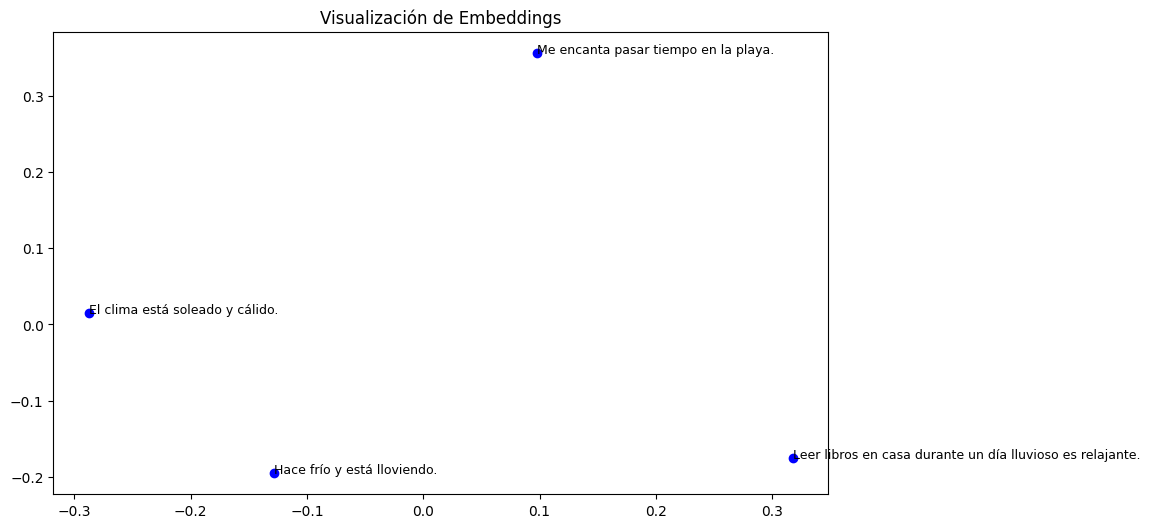

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2 dimensiones
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_list)

# Graficar los embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue')
for i, text in enumerate(texts):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], text, fontsize=9)
plt.title("Visualización de Embeddings")
plt.show()

# Ejercicio 3: Detección de temas con clustering de embeddings
## Objetivo: Agrupar textos con embeddings similares utilizando k-means.

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embeddings_list)
labels = kmeans.labels_

# Mostrar resultados de clustering
for i, text in enumerate(texts):
    print(f"Texto: {text} - Cluster: {labels[i]}")

Texto: El clima está soleado y cálido. - Cluster: 0
Texto: Hace frío y está lloviendo. - Cluster: 0
Texto: Me encanta pasar tiempo en la playa. - Cluster: 1
Texto: Leer libros en casa durante un día lluvioso es relajante. - Cluster: 1


# Ejercicio 4: Construcción de un motor de búsqueda simple con embeddings
## Objetivo: Implementar un motor de búsqueda que retorne el texto más similar a una consulta usando embeddings.


In [16]:
query = "Me gusta la playa"
response = client.embeddings.create(
        model=deployment,
        input=text
    )
query_embedding = response.data[0].embedding 

# Calcular similitud entre la consulta y la lista de textos anteriores
similarities = cosine_similarity([query_embedding], embeddings_list)[0]
most_similar_index = np.argmax(similarities)

print("Consulta:", query)
print("Texto más similar:", texts[most_similar_index])

Consulta: Me gusta la playa
Texto más similar: Leer libros en casa durante un día lluvioso es relajante.
